In [1]:
print("""

Earlham College Team
---------------------------------------------

Bach Pham (Vietnam)               - Freshman

Samadhi Chandrasena (Australia)   - Junior

Sora Owada (Japan)                - Sophomore



""")



Earlham College Team
---------------------------------------------

Bach Pham (Vietnam)               - Freshman

Samadhi Chandrasena (Australia)   - Junior

Sora Owada (Japan)                - Sophomore






In [2]:
import datetime
now = datetime.datetime.now()
print(now.strftime("%Y-%m-%d %H:%M:%S"))

2024-11-09 16:12:28


In [3]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Add, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import json
import matplotlib.pyplot as plt
import os
import numpy as np
import time
print(tf.__version__) # if not 2.15.0 then we r cooked :)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


In [4]:
# normalize /255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, label_file, batch_size, augment=True):
        self.image_dir = image_dir
        self.batch_size = batch_size
        
        # Read labels
        self.image_files = []
        self.labels = []
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                self.image_files.append(parts[0])
                self.labels.append([int(x) for x in parts[1:]])
        
        self.labels = np.array(self.labels)
        self.n_samples = len(self.image_files)
        self.indices = np.arange(self.n_samples)
        np.random.shuffle(self.indices)
        
        self.augment = augment
        
        # Define augmentation parameters
        self.zoom_range = (0.9, 1.1)
        
    def __len__(self):
        return int(np.ceil(self.n_samples / self.batch_size))
    
    def __getitem__(self, idx):
        batch_x = []
        batch_y = []
        
        batch_indices = self.indices[idx * self.batch_size:
                                   min((idx + 1) * self.batch_size, self.n_samples)]
        
        for i in batch_indices:
            # load and read image
            img_path = os.path.join(self.image_dir, self.image_files[i])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if self.augment:
                # Random horizontal flip
                if np.random.random() > 0.5:
                    img = cv2.flip(img, 1)
                
                # Random zoom
                zoom_factor = np.random.uniform(self.zoom_range[0], self.zoom_range[1])
                h, w = img.shape
                zh = int(np.round(h * zoom_factor))
                zw = int(np.round(w * zoom_factor))
                
                if zoom_factor > 1:
                    # Zoom in: crop the zoomed image
                    img = cv2.resize(img, (zw, zh))
                    crop_h = (zh - h) // 2
                    crop_w = (zw - w) // 2
                    img = img[crop_h:crop_h + h, crop_w:crop_w + w]
                else:
                    # Zoom out: pad the image
                    img_zoomed = cv2.resize(img, (zw, zh))
                    pad_h = (h - zh) // 2
                    pad_w = (w - zw) // 2
                    img = np.pad(img_zoomed, ((pad_h, h - zh - pad_h), (pad_w, w - zw - pad_w)), 
                               mode='constant', constant_values=0)
            
            # Normalize
            img = img.astype('float32') / 255.0
            
            batch_x.append(img)
            batch_y.append(self.labels[i])
            
        return np.array(batch_x)[..., np.newaxis], np.array(batch_y)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

train_generator = MultiLabelDataGenerator(
    'Cxnet_set',
    'labels/train_list.txt',
    batch_size=64,
    augment=True
)

val_generator = MultiLabelDataGenerator(
    'Cxnet_set',
    'labels/val_list.txt',
    batch_size=64,
    augment=False
)

In [5]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    if stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    return x

In [6]:
def ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 512, stride=2)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(1536)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    x = Dense(192)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    return Model(inputs, outputs)

input_shape = (245, 245, 1)
# 14 diseases
num_classes = 14
start_time = time.time()
# train part
model = ResNet(input_shape, num_classes)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=0.0003), # we tried 0.001, 0.0003, 0.0004 0.0001, 0.00007, 0.000001
    metrics=[tf.keras.metrics.AUC(multi_label=True)]
)
# observe and adjust. 
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint('best_EC_team_model.h5', monitor='val_auc', mode='max', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks
)

print('Time in minutes:', ((time.time()-start_time)/60))
print('Time in hours:', ((time.time()-start_time)/3600))

Epoch 1/100


I0000 00:00:1731186758.944951  217303 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1227/1227 [==============================] - ETA: 0s - loss: 0.2126 - auc: 0.5452

/mounts/faraday/software/anaconda/envs/py311/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1227/1227 [==============================] - 146s 108ms/step - loss: 0.2126 - auc: 0.5452 - val_loss: 0.1870 - val_auc: 0.5971 - lr: 3.0000e-04
Epoch 2/100
1227/1227 [==============================] - 125s 102ms/step - loss: 0.1769 - auc: 0.6217 - val_loss: 0.2032 - val_auc: 0.6095 - lr: 3.0000e-04
Epoch 3/100
1227/1227 [==============================] - 132s 107ms/step - loss: 0.1736 - auc: 0.6510 - val_loss: 0.2019 - val_auc: 0.6239 - lr: 3.0000e-04
Epoch 4/100
1227/1227 [==============================] - 138s 112ms/step - loss: 0.1702 - auc: 0.6791 - val_loss: 0.1883 - val_auc: 0.6222 - lr: 2.1000e-04
Epoch 5/100
1227/1227 [==============================] - 132s 108ms/step - loss: 0.1684 - auc: 0.6919 - val_loss: 0.2300 - val_auc: 0.5539 - lr: 2.1000e-04
Epoch 6/100
1227/1227 [==============================] - 148s 121ms/step - loss: 0.1663 - auc: 0.7097 - val_loss: 0.1668 - val_auc: 0.7293 - lr: 1.4700e-04
Epoch 7/100
1227/1227 [==============================] - 130s 106ms/step - l

In [7]:
# the result
model_json = model.to_json()
with open("EC_Hackathon_Team.json", "w") as json_file:
    json_file.write(model_json)

model.save("EC_Hackathon_Team.h5")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 245, 245, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 245, 245, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 245, 245, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 245, 245, 32)         0         ['batch_normalization[0][0

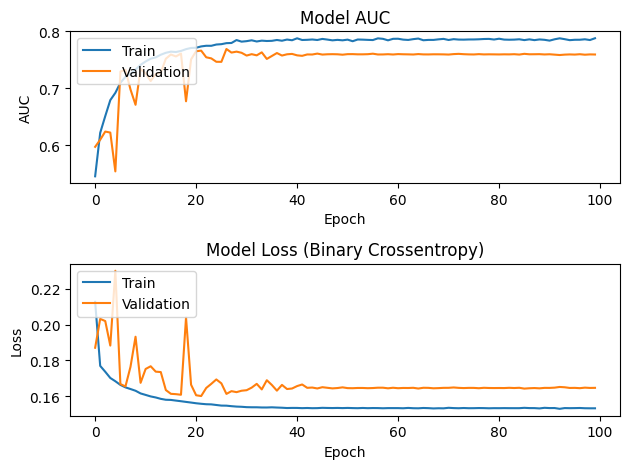

In [8]:
plt.figure(1)
# AUC for multi-label (should be better because it treats each category separately)
plt.subplot(211)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (Binary Crossentropy)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('model_performance.png')
plt.show()

# save model performance metrics
performance_metrics = {
    'final_loss': float(history.history['loss'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1]),
    'final_auc': float(history.history['auc'][-1]),
    'final_val_auc': float(history.history['val_auc'][-1]),
    'best_val_auc': float(max(history.history['val_auc'])),
    'best_epoch': history.history['val_auc'].index(max(history.history['val_auc'])) + 1
}

with open('model_metrics.json', 'w') as f:
    json.dump(performance_metrics, f, indent=4)